### Data Preprocessing, Plotting, and Error Metrics
* Data reading from a csv file to a dataframe
* Data normalization
* Data splitting
* Plotting
* Error metrics

Modified from https://github.com/pratha19/Hourly_Energy_Consumption_Prediction/blob/master/SDGE_energy_ML.ipynb

In [36]:
# Import basic modules
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

#### Data reading

In [37]:
def read_owm_data(fn):
    data = pd.read_csv(fn)
    data = data.rename(columns=lambda x: x.strip())  
    
    dates = (data['timestamp']//1000).apply(lambda x: datetime.fromtimestamp(x))
    data.insert(loc=0, column='Dates', value=dates)
    data = data.set_index('Dates')
    data = data.rename(columns={"pwr": "SDGE"})

    time_rs = (data['timestamp'] - data['sunrise']) / (data['sunset'] - data['sunrise'])
    data.insert(loc=len(data.columns)-1, column='time_rs', value=time_rs)

    sdge = data.drop(['timestamp','sunrise','sunset'], axis=1) 
    sdge_lin = pd.get_dummies(sdge)
    
    return sdge_lin, ['temp', 'humidity', 'rain', 'cloud', 'visibility','time_rs']

In [38]:
sdge_lin,cols_to_transform = read_owm_data('all_owm.csv')
print(sdge_lin.head())

                     temp  humidity  rain  cloud  visibility  time_rs  SDGE
Dates                                                                      
2020-02-18 00:00:00  22.0      56.0   0.0    0.0        90.0    -0.53   0.0
2020-02-18 01:00:00  21.0      56.0   0.0    0.0        90.0    -0.44   0.0
2020-02-18 02:00:00  20.0      60.0   0.0    0.0        80.0    -0.35   0.0
2020-02-18 03:00:00  19.0      63.0   0.0    0.0        80.0    -0.26   0.0
2020-02-18 04:00:00  19.0      63.0   0.0    0.0        80.0    -0.17   0.0


#### Data splitting

In [39]:
def train_test(data, test_size = 0.15, test_num = -1, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # get the index after which test set starts
    if test_num == -1:
        test_index = int(len(df)*(1-test_size))
    else:
        test_index = len(df) - test_num
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]    
    
    return X_train, X_test, y_train, y_test

def train_test_rand(data, test_size = 0.15, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    data_X = df.drop('SDGE', axis = 1)
    data_Y = df.SDGE
    X_train0, X_test0, y_train0, y_test0 = train_test_split(data_X, data_Y, test_size=test_size, random_state=7)
    
    X_train = X_train0.copy(deep=True)
    X_test = X_test0.copy(deep=True)
    y_train = y_train0.copy(deep=True)
    y_test = y_test0.copy(deep=True)    
    
    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_test, y_train, y_test = train_test_rand(sdge_lin, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)

print(X_train.head())

                         temp  humidity      rain     cloud  visibility  \
Dates                                                                     
2020-10-16 00:00:00 -1.190345  1.466499 -0.143343  0.917205    0.709914   
2020-04-20 18:00:00  2.397436 -1.786059 -0.143343 -0.996756    0.709914   
2020-02-20 19:00:00  0.346178 -1.898217 -0.143343 -1.692742    0.709914   
2020-09-14 00:00:00 -0.678171  1.466499 -0.143343 -0.996756   -0.031925   
2020-03-25 11:00:00  0.850669 -1.617824 -0.106777 -1.588344   -0.773764   

                      time_rs  
Dates                          
2020-10-16 00:00:00 -1.434768  
2020-04-20 18:00:00  0.934180  
2020-02-20 19:00:00  0.917088  
2020-09-14 00:00:00 -1.800537  
2020-03-25 11:00:00 -0.149452  


In [41]:
X_train, X_test, y_train, y_test = train_test(sdge_lin, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)

print(X_train.head())

                         temp  humidity      rain     cloud  visibility  \
Dates                                                                     
2020-02-18 00:00:00 -1.702519 -1.000959 -0.143343 -1.692742   -0.031925   
2020-02-18 01:00:00 -1.958606 -1.000959 -0.143343 -1.692742   -0.031925   
2020-02-18 02:00:00 -2.214694 -0.776645 -0.143343 -1.692742   -0.773764   
2020-02-18 03:00:00 -2.470781 -0.608409 -0.143343 -1.692742   -0.773764   
2020-02-18 04:00:00 -2.470781 -0.608409 -0.143343 -1.692742   -0.773764   

                      time_rs  
Dates                          
2020-02-18 00:00:00 -1.697985  
2020-02-18 01:00:00 -1.544157  
2020-02-18 02:00:00 -1.390329  
2020-02-18 03:00:00 -1.236501  
2020-02-18 04:00:00 -1.082674  


#### Data normalization
* Standard scaler
![Standard scaler](https://i.stack.imgur.com/obywE.png)

* Min-max scaler
![Min-max scaler](https://static.packt-cdn.com/products/9781789808452/graphics/c4212323-5a69-4a28-96ef-b503014b7784.png)

In [42]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 4 samples/observations and 2 variables/features
data = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

print(data)
print(scaled_data)

[[0 0]
 [1 0]
 [0 1]
 [1 1]]
[[-1. -1.]
 [ 1. -1.]
 [-1.  1.]
 [ 1.  1.]]


In [43]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 4 samples/observations and 2 variables/features
data = np.array([[0, 0], [10, 0], [0, 10], [10, 10]])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# scale more samples
new_data = np.array([[1,1],[2,2]])
scaled_new_data = scaler.transform(new_data)

# inverse scaled samples
inversed_scaled_new_data = scaler.inverse_transform(scaled_new_data)

print(data)
print(scaled_data)
print(scaled_new_data)
print(inversed_scaled_new_data)

[[ 0  0]
 [10  0]
 [ 0 10]
 [10 10]]
[[0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 1.]]
[[0.1 0.1]
 [0.2 0.2]]
[[1. 1.]
 [2. 2.]]


#### Plotting
One axis

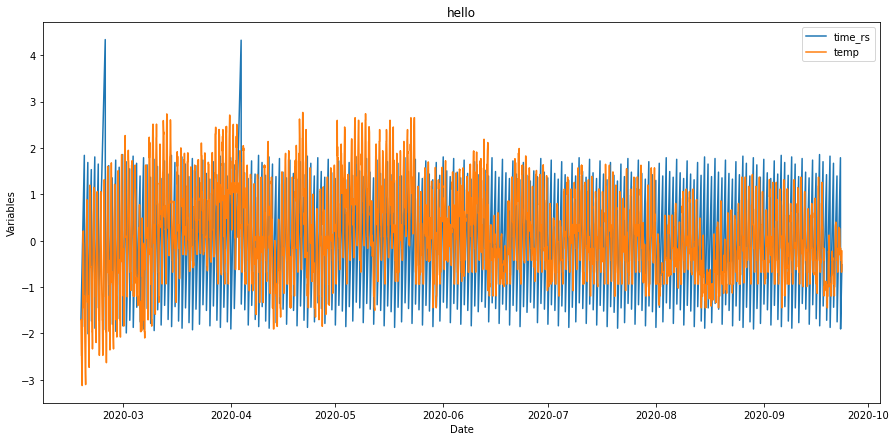

In [44]:
plt.figure(figsize = (15,7))
_ = plt.plot(X_train.index.values, X_train["time_rs"].values, label='time_rs')
_ = plt.plot(X_train.index.values, X_train["temp"].values, label='temp')
#_ = plt.plot(X_train.index.values, y_train.values, label='pwr')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Variables')
_ = plt.legend()
_ = plt.title('hello')

Multiple axes

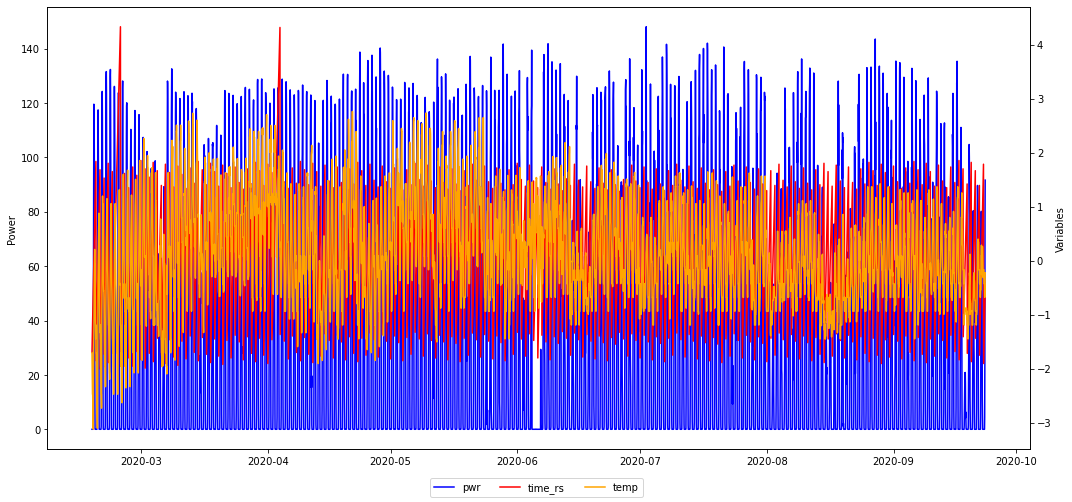

In [45]:
fig, ax1 = plt.subplots(figsize=(15,7))

ax1.set_ylabel('Power')  # we already handled the x-label with ax1
ax1.plot(X_train.index.values, y_train.values, label='pwr', color='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_xlabel('Date')
ax2.set_ylabel('Variables')
ax2.plot(X_train.index.values, X_train["time_rs"].values, label='time_rs', color='red')
ax2.plot(X_train.index.values, X_train["temp"].values, label='temp', color='orange')

fig.tight_layout() 
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=['pwr','time_rs','temp'], loc="lower center", ncol=3)

Multiple subplots

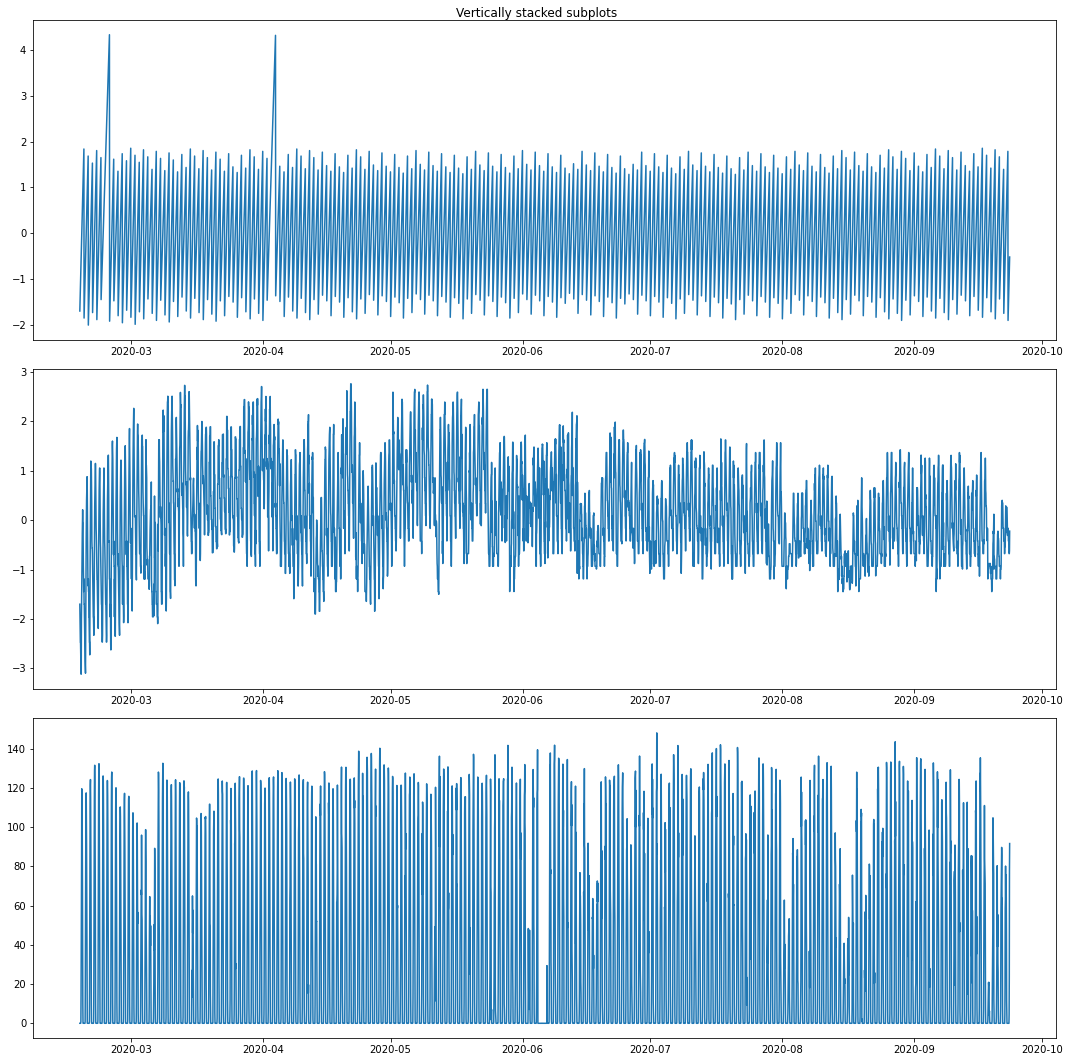

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))
fig.suptitle('Vertically stacked subplots')
ax1.plot(X_train.index.values, X_train["time_rs"].values, label='time_rs')
ax2.plot(X_train.index.values, X_train["temp"].values, label='temp')
ax3.plot(X_train.index.values, y_train.values, label='pwr')

fig.tight_layout() 

Scatter plot

In [47]:
x = np.arange(100)
delta = np.random.uniform(-10,10, size=(100,))
y = x + delta

print(y)

[ 9.05864275e+00 -5.77327763e+00 -6.96103794e-01  3.10712340e-01
 -4.85675699e+00  1.21804900e+01  1.26761442e+00 -5.27329818e-02
  6.21219931e+00 -3.99808213e-01  1.83748896e+01  7.74661732e+00
  9.64445133e+00  8.55311706e+00  9.14067047e+00  7.65051485e+00
  1.72580890e+01  1.10975395e+01  9.12783956e+00  2.82232445e+01
  2.49813111e+01  2.90817025e+01  1.87579693e+01  1.54558459e+01
  2.86235005e+01  1.82916525e+01  2.17505680e+01  2.00619221e+01
  2.20837622e+01  2.83362796e+01  3.16991437e+01  2.84557687e+01
  3.70602332e+01  2.77729430e+01  2.99140364e+01  2.88310047e+01
  3.41196320e+01  3.54126003e+01  4.36983934e+01  4.54673566e+01
  3.16815480e+01  4.82109681e+01  3.97461425e+01  4.52813198e+01
  3.85773926e+01  4.70405430e+01  4.67267317e+01  4.16544917e+01
  4.29762066e+01  4.71433842e+01  4.02180367e+01  4.15829036e+01
  5.48470107e+01  4.38714291e+01  4.67511891e+01  5.98108666e+01
  5.52468330e+01  5.52022267e+01  6.51651927e+01  5.49868315e+01
  6.77069790e+01  6.71204

Text(0, 0.5, 'y')

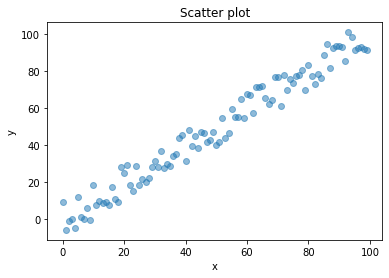

In [48]:
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')

#### Error metrics
* Root mean square error
![RMSE](https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png)

* Mean absolute error
![MAE](https://i.imgur.com/BmBC8VW.jpg)

* R-squared measure
![R2](https://miro.medium.com/max/700/1*JwEiZQSkL4I710994WaY4w.png)



In [49]:
def error_metrics(y_pred, y_truth, model_name = None):
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)  

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)
    
    # Explained variance score: 1 is perfect prediction
    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )
    
    name_error = ['model', 'RMSE', 'MAE', 'R2']
    value_error = [model_name, RMSE, MAE, R2]
    list_error = list(zip(name_error, value_error))
    
    # Creating an empty dict to save all the erros from different models
    dict_error = dict()
    
    for error in list_error:
        dict_error[error[0]] = error[1]
        
    return(dict_error)

In [50]:
y = np.arange(100)
delta = np.random.uniform(-10,10, size=(100,))
y_hat = y + delta

error_metrics(y_hat,y,'Test model')


Error metrics for model Test model
RMSE or Root mean squared error: 5.59
Mean Absolute Error: 4.86
Variance score: 0.96


{'model': 'Test model',
 'RMSE': 5.58906165385866,
 'MAE': 4.864667002342386,
 'R2': 0.9625111189071307}

#### Put 'em all together

In [51]:
# Import basic modules
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

def read_owm_data(fn):
    data = pd.read_csv(fn)
    data = data.rename(columns=lambda x: x.strip())  
    
    dates = (data['timestamp']//1000).apply(lambda x: datetime.fromtimestamp(x))
    data.insert(loc=0, column='Dates', value=dates)
    data = data.set_index('Dates')
    data = data.rename(columns={"pwr": "SDGE"})

    time_rs = (data['timestamp'] - data['sunrise']) / (data['sunset'] - data['sunrise'])
    data.insert(loc=len(data.columns)-1, column='time_rs', value=time_rs)

    sdge = data.drop(['timestamp','sunrise','sunset'], axis=1) 
    sdge_lin = pd.get_dummies(sdge)
    
    return sdge_lin, ['temp', 'humidity', 'rain', 'cloud', 'visibility','time_rs']

def train_test(data, test_size = 0.15, test_num = -1, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # get the index after which test set starts
    if test_num == -1:
        test_index = int(len(df)*(1-test_size))
    else:
        test_index = len(df) - test_num
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]    
    
    return X_train, X_test, y_train, y_test

def train_test_rand(data, test_size = 0.15, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    data_X = df.drop('SDGE', axis = 1)
    data_Y = df.SDGE
    X_train0, X_test0, y_train0, y_test0 = train_test_split(data_X, data_Y, test_size=test_size, random_state=7)
    
    X_train = X_train0.copy(deep=True)
    X_test = X_test0.copy(deep=True)
    y_train = y_train0.copy(deep=True)
    y_test = y_test0.copy(deep=True)    
    
    return X_train, X_test, y_train, y_test

def error_metrics(y_pred, y_truth, model_name = None):
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)  

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)
    
    # Explained variance score: 1 is perfect prediction
    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )
    
    name_error = ['model', 'RMSE', 'MAE', 'R2']
    value_error = [model_name, RMSE, MAE, R2]
    list_error = list(zip(name_error, value_error))
    
    # Creating an empty dict to save all the erros from different models
    dict_error = dict()
    
    for error in list_error:
        dict_error[error[0]] = error[1]
        
    return(dict_error)